<a href="https://colab.research.google.com/github/juantijero/ML_HW/blob/main/Used_Car_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
import pandas as pd
import glob
import os

# --- PART A: DATA INGESTION ---
print("Step 1: Downloading dataset from Kaggle...")
path = kagglehub.dataset_download("adityadesai13/used-car-dataset-ford-and-mercedes")
print(f"Data cached at: {path}")

# --- PART B: DATA INTEGRATION (The Loop) ---
print("Step 2: Processing individual files...")
all_files = glob.glob(os.path.join(path, "*.csv"))

df_list = [] # A list to hold our 9 dataframes before merging

for filename in all_files:
    # 1. Read the CSV into memory
    df = pd.read_csv(filename)

    # 2. Extract manufacturer from the filename (e.g., "audi.csv" -> "Audi")
    manufacturer_name = os.path.basename(filename).split('.')[0].capitalize()
    df['manufacturer'] = manufacturer_name

    # 3. Fix the specific column inconsistency
    # Some files use 'tax', others 'tax(£)'. We standardize to 'tax'.
    if 'tax(£)' in df.columns:
        df.rename(columns={'tax(£)': 'tax'}, inplace=True)

    df_list.append(df)
    print(f"   -> Added {manufacturer_name} ({len(df)} rows)")

# --- PART C: MERGING & SAVING ---
print("Step 3: Merging all data...")
master_df = pd.concat(df_list, ignore_index=True)

# Save the result to your local project folder
output_filename = 'uk_used_cars_merged.csv'
master_df.to_csv(output_filename, index=False)

print("-" * 30)
print(f"DONE. Master dataset saved as: {output_filename}")
print(f"Total Cars: {len(master_df)}")
print(f"Columns: {list(master_df.columns)}")

Step 1: Downloading dataset from Kaggle...


100%|██████████| 1.10M/1.10M [00:00<00:00, 74.2MB/s]

Extracting files...
Data cached at: /root/.cache/kagglehub/datasets/adityadesai13/used-car-dataset-ford-and-mercedes/versions/3
Step 2: Processing individual files...
   -> Added Merc (13119 rows)


   -> Added Bmw (10781 rows)
   -> Added Ford (17965 rows)
   -> Added Vw (15157 rows)
   -> Added Audi (10668 rows)
   -> Added Toyota (6738 rows)
   -> Added Hyundi (4860 rows)
   -> Added Vauxhall (13632 rows)
   -> Added Unclean cclass (4006 rows)
   -> Added Unclean focus (5604 rows)
   -> Added Cclass (3899 rows)
   -> Added Focus (5454 rows)
   -> Added Skoda (6267 rows)
Step 3: Merging all data...
------------------------------
DONE. Master dataset saved as: uk_used_cars_merged.csv
Total Cars: 118150
Columns: ['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax', 'mpg', 'engineSize', 'manufacturer', 'fuel type', 'engine size', 'mileage2', 'fuel type2', 'engine size2', 'reference']


--- Raw Data Health Check ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118150 entries, 0 to 118149
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   model         117995 non-null  object 
 1   year          117903 non-null  float64
 2   price         117995 non-null  object 
 3   transmission  117995 non-null  object 
 4   mileage       117077 non-null  object 
 5   fuelType      108540 non-null  object 
 6   tax           99187 non-null   float64
 7   mpg           99187 non-null   float64
 8   engineSize    108540 non-null  float64
 9   manufacturer  118150 non-null  object 
 10  fuel type     3517 non-null    object 
 11  engine size   9345 non-null    object 
 12  mileage2      9399 non-null    object 
 13  fuel type2    8537 non-null    object 
 14  engine size2  8537 non-null    object 
 15  reference     9455 non-null    object 
dtypes: float64(4), object(12)
memory usage: 14.4+ MB
None


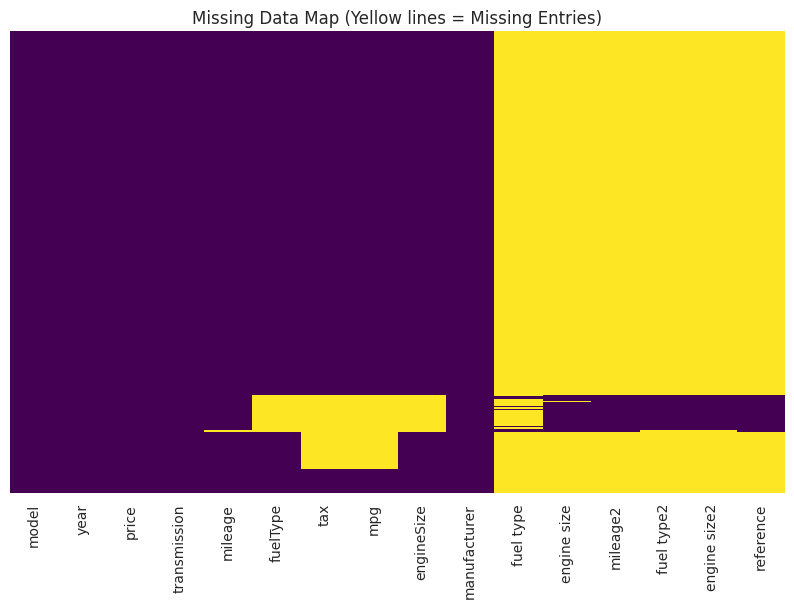

Price column type: object
ALERT: Price is text! Needs cleaning.


In [4]:
# --- BLOCK 2: INSPECTION ---
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create a copy so we don't mess up master_df if we need to re-run
df = master_df.copy()

print("--- Raw Data Health Check ---")
print(df.info())

# Visualize Missing Data Map
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Data Map (Yellow lines = Missing Entries)')
plt.show()

# Check for the specific "Price is a String" error
print(f"Price column type: {df['price'].dtype}")
if df['price'].dtype == 'O':
    print("ALERT: Price is text! Needs cleaning.")

In [5]:
# --- BLOCK 3: CLEANING ---
print("--- Starting Cleaning Process ---")
original_count = len(df)

# 1. Fix "Price" (Remove £ and ,)
# We cast to string first to handle any weird formatting
df['price'] = df['price'].astype(str).str.replace('£', '', regex=False).str.replace(',', '', regex=False)
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# 2. Fix "Mileage" (Remove ,)
# Sometimes mileage has commas too (e.g., "15,000")
if df['mileage'].dtype == 'O':
    df['mileage'] = df['mileage'].astype(str).str.replace(',', '', regex=False)
    df['mileage'] = pd.to_numeric(df['mileage'], errors='coerce')

# 3. Drop rows with NO PRICE (Crucial for Regression)
df.dropna(subset=['price'], inplace=True)

# 4. Handle Missing Tax/MPG
# If a row is missing essential info, we drop it (Scenario B)
df.dropna(subset=['tax', 'mpg'], inplace=True)

# 5. Handle "Ghost" Cars (Engine Size = 0)
# Replace 0.0 engine size with the median
median_engine = df['engineSize'].median()
df['engineSize'] = df['engineSize'].replace(0, median_engine)

# Final Count
current_count = len(df)
print(f"Rows Removed: {original_count - current_count}")
print(f"Remaining Clean Data: {current_count}")

--- Starting Cleaning Process ---
Rows Removed: 18963
Remaining Clean Data: 99187


--- Generating Market Insights ---


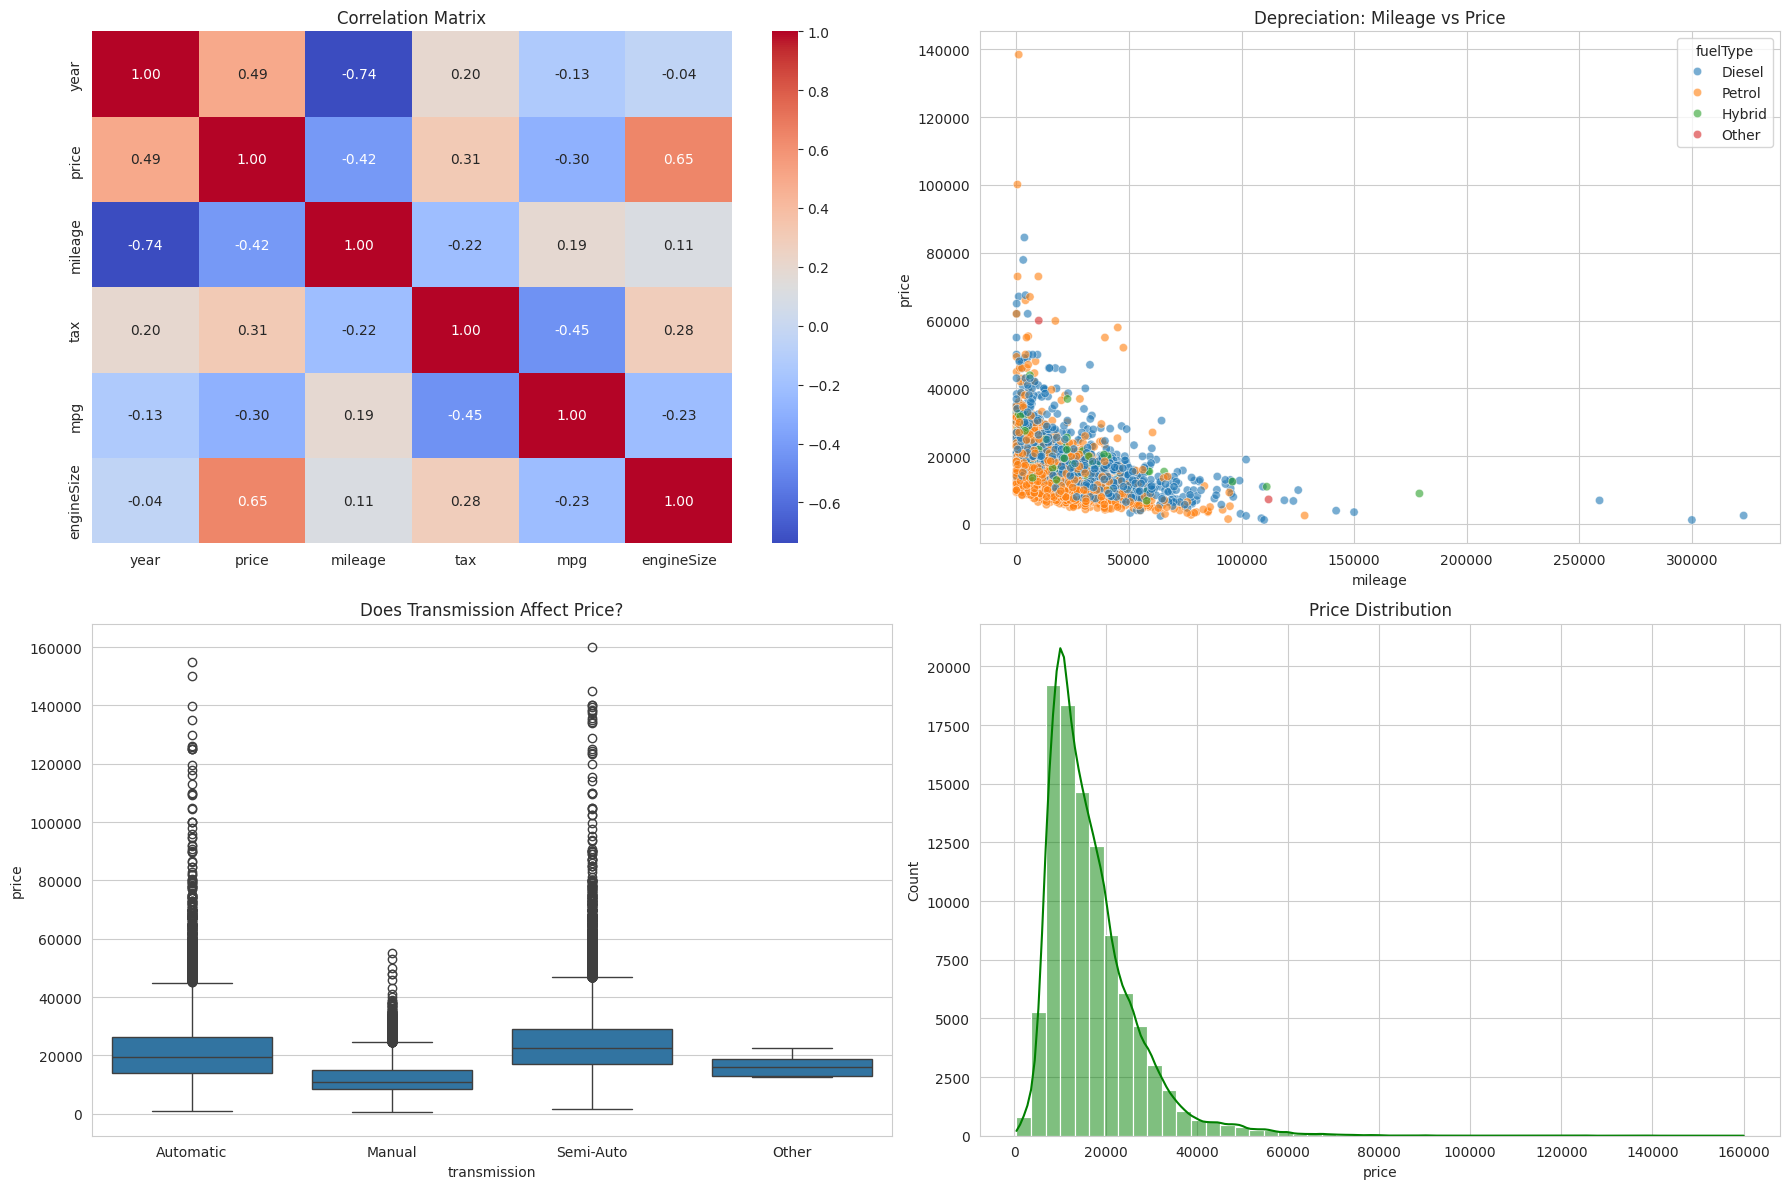

In [6]:
# --- BLOCK 4: ANALYSIS ---
print("--- Generating Market Insights ---")

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Graph 1: Correlation (The Cheat Sheet)
# We only select numeric columns to avoid errors
numeric_df = df.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", ax=axes[0, 0])
axes[0, 0].set_title('Correlation Matrix')

# Graph 2: Mileage vs Price (Depreciation)
# Sampling 2000 points prevents the graph from being a solid blob of color
sns.scatterplot(data=df.sample(2000), x='mileage', y='price', hue='fuelType', alpha=0.6, ax=axes[0, 1])
axes[0, 1].set_title('Depreciation: Mileage vs Price')

# Graph 3: Transmission vs Price
sns.boxplot(x='transmission', y='price', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Does Transmission Affect Price?')

# Graph 4: Price Distribution (Target Variable)
sns.histplot(df['price'], bins=50, kde=True, color='green', ax=axes[1, 1])
axes[1, 1].set_title('Price Distribution')

plt.tight_layout()
plt.show()

In [8]:
# --- BLOCK 5: PRE-PROCESSING (REVISED) ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

print("--- Starting Feature Engineering (Safety Mode) ---")

# 1. CLEAN UP GHOST COLUMNS (Before Encoding)
# We strictly select only the columns we expect to exist.
# This filters out the weird "fuel type engine size" columns you saw.
expected_cols = ['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax', 'mpg', 'engineSize', 'manufacturer']
# Only keep columns that are in our expected list
df_clean = df[df.columns.intersection(expected_cols)].copy()

# 2. ONE-HOT ENCODING (Now including 'model')
# We convert 'model' (Focus, Fiesta) into numbers.
# This will add ~150 columns (one for each car model), which is fine for this size of data.
categorical_cols = ['transmission', 'fuelType', 'manufacturer', 'model']
df_processed = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

# 3. FEATURE SCALING
scaler = StandardScaler()
numerical_cols = ['mileage', 'tax', 'mpg', 'engineSize', 'year']
df_processed[numerical_cols] = scaler.fit_transform(df_processed[numerical_cols])

# 4. FINAL CLEANUP (Drop any lingering non-numeric columns)
# This ensures ONLY numbers are left.
df_processed = df_processed.select_dtypes(include=[np.number])

# 5. SPLIT DATA
X = df_processed.drop('price', axis=1)
y = df_processed['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("--- Processing Complete ---")
print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

# VALIDATION: Check for text or NaNs
print("\nValidation Check:")
print(f"Any NaN values? {X_train.isnull().values.any()}")
print(f"Any Text columns? {X_train.select_dtypes(include=['object']).columns.tolist()}")
# If these print "False" and "[]", you are 100% ready for the Neural Network.

--- Starting Feature Engineering (Safety Mode) ---
--- Processing Complete ---
Training Data Shape: (79349, 5)
Testing Data Shape: (19838, 5)

Validation Check:
Any NaN values? False
Any Text columns? []


--- Training Baseline Model (Linear Regression) ---

--- Results ---
Average Car Price: £16,805.35
Model Error (RMSE): £5,346.55
Error Percentage:   31.81% (Goal: <10%)
R² Score:           0.7149


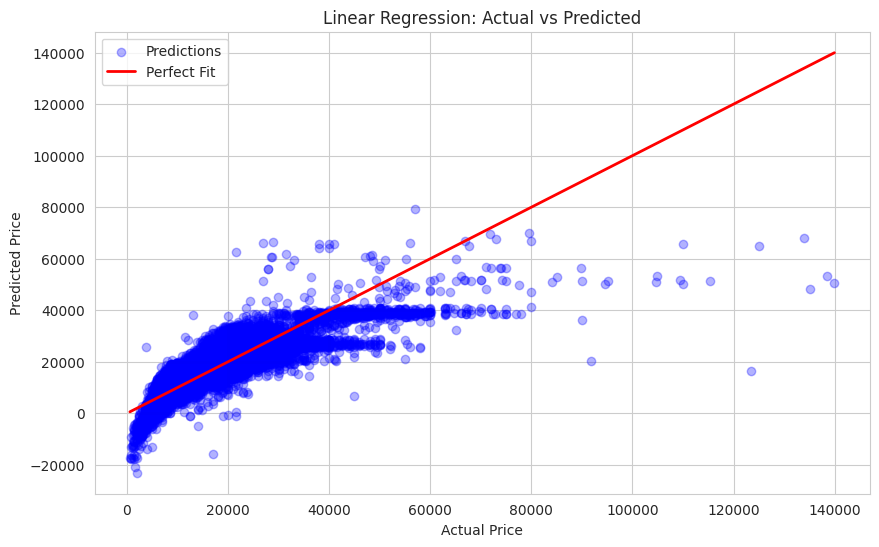

In [9]:
# --- BLOCK 6: LINEAR REGRESSION BASELINE ---
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

print("--- Training Baseline Model (Linear Regression) ---")

# 1. Initialize and Train
# This finds the "Line of Best Fit" through your 150+ dimensions.
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# 2. Predict
# We ask the model to guess the prices for the test set (cars it has never seen).
y_pred_lr = lr_model.predict(X_test)

# 3. Evaluate
# RMSE: How much money are we off by on average? (Lower is better)
# R2: How well does the model fit the data? (1.0 is perfect, 0.0 is useless)
mse = mean_squared_error(y_test, y_pred_lr)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_lr)
r2 = r2_score(y_test, y_pred_lr)

# Calculate if we met the "10% Error" goal
avg_price = df['price'].mean()
error_percentage = (rmse / avg_price) * 100

print(f"\n--- Results ---")
print(f"Average Car Price: £{avg_price:,.2f}")
print(f"Model Error (RMSE): £{rmse:,.2f}")
print(f"Error Percentage:   {error_percentage:.2f}% (Goal: <10%)")
print(f"R² Score:           {r2:.4f}")

# 4. Visualization (Actual vs Predicted)
# Perfect predictions would line up exactly on the red diagonal line.
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.3, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, label='Perfect Fit')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Linear Regression: Actual vs Predicted')
plt.legend()
plt.show()

In [15]:
# --- BLOCK 7 (MODIFIED): THE BIGGER BRAIN ---
class CarPriceNet(nn.Module):
    def __init__(self, input_size):
        super(CarPriceNet, self).__init__()
        # 1. Much larger first layer (256 neurons instead of 64)
        self.layer1 = nn.Linear(input_size, 256)

        # 2. Add an extra layer and keep them big
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)

        # 3. Output layer
        self.layer4 = nn.Linear(64, 1)

        self.relu = nn.ReLU()

        # Dropout: Randomly turns off neurons to force the others to learn harder.
        # This helps preventing "memorizing" the data.
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x) # Apply dropout

        x = self.relu(self.layer2(x))
        x = self.dropout(x)

        x = self.relu(self.layer3(x))
        x = self.layer4(x)
        return x

# Initialize
input_features = X_train.shape[1]
model = CarPriceNet(input_features)
criterion = nn.MSELoss()
# Lower learning rate slightly for the bigger model
optimizer = optim.Adam(model.parameters(), lr=0.005)

print("--- Big Model Initialized ---")

--- Big Model Initialized ---


In [11]:
# --- BLOCK 7: NEURAL NETWORK SETUP ---
import torch
import torch.nn as nn
import torch.optim as optim

print("--- Building Neural Network ---")

# 1. CONVERT DATA TO PYTORCH TENSORS
# PyTorch works with Tensors (matrices), not DataFrames.
# We also move them to .float32 because that's what NNs expect.
X_train_tensor = torch.tensor(X_train.values).float()
y_train_tensor = torch.tensor(y_train.values).view(-1, 1).float() # Reshape to column
X_test_tensor = torch.tensor(X_test.values).float()
y_test_tensor = torch.tensor(y_test.values).view(-1, 1).float()

# 2. DEFINE THE NETWORK ARCHITECTURE
class CarPriceNet(nn.Module):
    def __init__(self, input_size):
        super(CarPriceNet, self).__init__()
        # Layer 1: Input -> Hidden Layer 1 (64 neurons)
        self.layer1 = nn.Linear(input_size, 64)

        # Layer 2: Hidden 1 -> Hidden Layer 2 (32 neurons)
        self.layer2 = nn.Linear(64, 32)

        # Layer 3: Hidden 2 -> Output (1 number: Price)
        self.layer3 = nn.Linear(32, 1)

        # Activation Function: ReLU (The "Bending" tool)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Pass input through Layer 1, then bend it (ReLU)
        x = self.relu(self.layer1(x))
        # Pass through Layer 2, then bend it (ReLU)
        x = self.relu(self.layer2(x))
        # Pass through Layer 3 (Output).
        # CRITICAL: No activation here! We want a raw number, not 0-1.
        x = self.layer3(x)
        return x

# 3. INITIALIZE MODEL
input_features = X_train.shape[1] # Number of columns (approx 150-200)
model = CarPriceNet(input_features)

# 4. DEFINE LOSS AND OPTIMIZER
# MSELoss: Calculates the squared difference between prediction and actual.
criterion = nn.MSELoss()
# Adam: The standard optimizer. Learning rate (lr) controls how fast it learns.
optimizer = optim.Adam(model.parameters(), lr=0.01)

print(f"Model Architecture:\n{model}")

--- Building Neural Network ---
Model Architecture:
CarPriceNet(
  (layer1): Linear(in_features=5, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)


--- Starting Training Loop ---
Epoch [50/500], Loss: 78474576.0000
Epoch [100/500], Loss: 32349568.0000
Epoch [150/500], Loss: 25953330.0000
Epoch [200/500], Loss: 24135092.0000
Epoch [250/500], Loss: 23242920.0000
Epoch [300/500], Loss: 22773094.0000
Epoch [350/500], Loss: 22430142.0000
Epoch [400/500], Loss: 22127340.0000
Epoch [450/500], Loss: 21992302.0000
Epoch [500/500], Loss: 21669158.0000
--- Training Complete ---


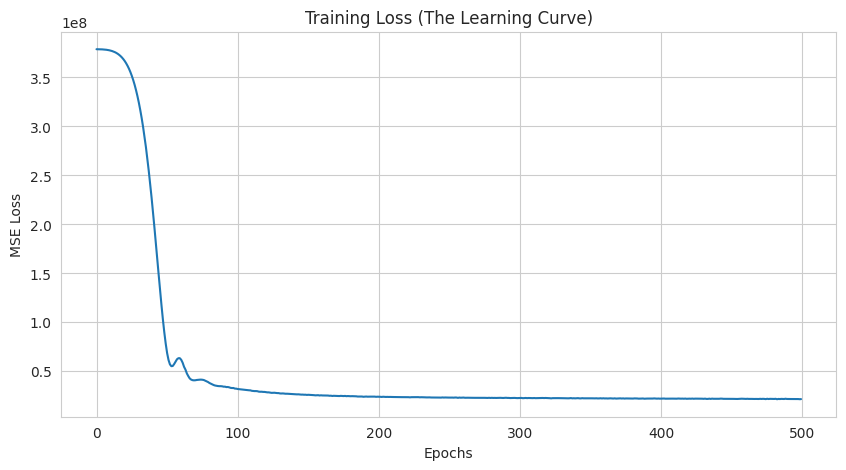

In [16]:
# --- BLOCK 8: TRAINING THE MODEL ---
print("--- Starting Training Loop ---")

epochs = 500
loss_history = []

for epoch in range(epochs):
    # A. Forward Pass (Make a guess)
    y_pred = model(X_train_tensor)

    # B. Calculate Error (Loss)
    loss = criterion(y_pred, y_train_tensor)

    # C. Backward Pass (Calculate adjustments)
    optimizer.zero_grad() # Clear old gradients
    loss.backward()       # Calculate new gradients
    optimizer.step()      # Update weights

    # D. Save loss for plotting
    loss_history.append(loss.item())

    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

print("--- Training Complete ---")

# Plot the learning curve
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title('Training Loss (The Learning Curve)')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.show()

--- Evaluating Neural Network ---

--- FINAL RESULTS ---
Baseline RMSE:      £5,346.55
Neural Net RMSE:    £4,563.18
Improvement:        £783.37 (14.65%)
Neural Net R²:      0.7923
Final Error %:      27.15% (Goal: <10%)


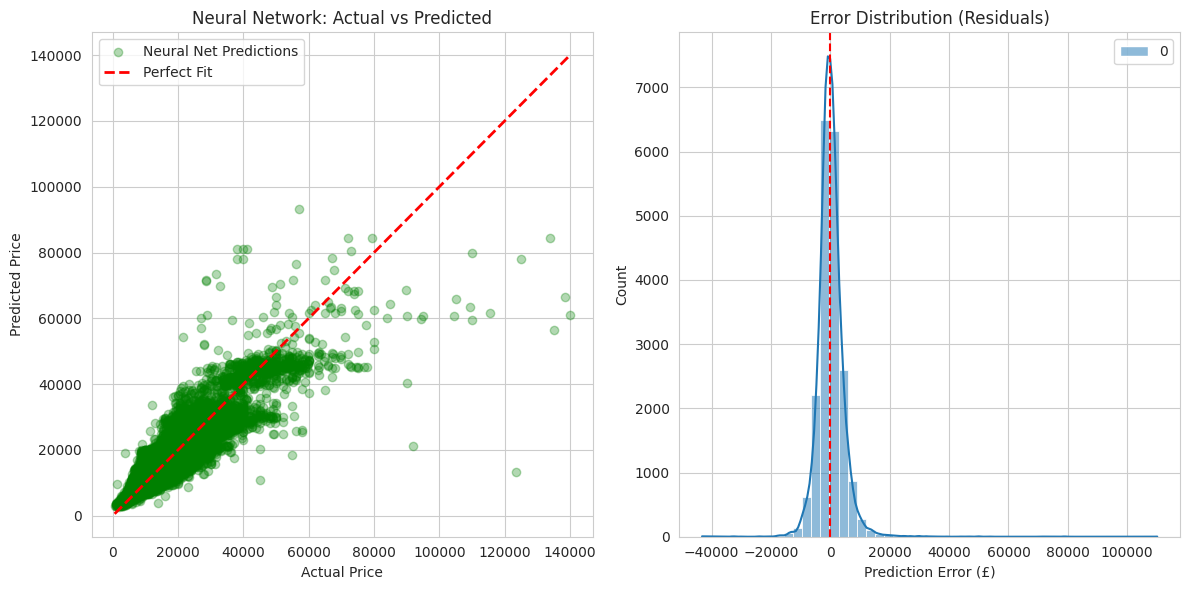

In [17]:
# --- BLOCK 9: FINAL EVALUATION ---
print("--- Evaluating Neural Network ---")

# 1. SWITCH TO EVALUATION MODE
# This tells PyTorch "we are testing, not learning", so it stops calculating gradients.
model.eval()

with torch.no_grad():
    # Make predictions on the test set
    y_pred_tensor = model(X_test_tensor)
    # Convert back to Numpy so we can use Scikit-Learn metrics
    y_pred_nn = y_pred_tensor.numpy()
    y_test_np = y_test_tensor.numpy()

# 2. CALCULATE METRICS
mse_nn = mean_squared_error(y_test_np, y_pred_nn)
rmse_nn = np.sqrt(mse_nn)
mae_nn = mean_absolute_error(y_test_np, y_pred_nn)
r2_nn = r2_score(y_test_np, y_pred_nn)

# 3. COMPARE WITH BASELINE (Linear Regression)
# We assume you still have the 'rmse' variable from Block 6
improvement = rmse - rmse_nn # (Old Error - New Error)
pct_improvement = (improvement / rmse) * 100

print(f"\n--- FINAL RESULTS ---")
print(f"Baseline RMSE:      £{rmse:,.2f}")
print(f"Neural Net RMSE:    £{rmse_nn:,.2f}")
print(f"Improvement:        £{improvement:,.2f} ({pct_improvement:.2f}%)")
print(f"Neural Net R²:      {r2_nn:.4f}")

# Check the <10% Goal
avg_price = df['price'].mean()
error_percentage_nn = (rmse_nn / avg_price) * 100
print(f"Final Error %:      {error_percentage_nn:.2f}% (Goal: <10%)")

# 4. VISUALIZATION
plt.figure(figsize=(12, 6))

# Plot 1: Scatter of Actual vs Predicted
plt.subplot(1, 2, 1)
plt.scatter(y_test_np, y_pred_nn, alpha=0.3, color='green', label='Neural Net Predictions')
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--', lw=2, label='Perfect Fit')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Neural Network: Actual vs Predicted')
plt.legend()

# Plot 2: Error Distribution (Residuals)
# Ideally, this looks like a bell curve centered at 0.
residuals = y_test_np - y_pred_nn
plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=50, kde=True, color='purple')
plt.title('Error Distribution (Residuals)')
plt.xlabel('Prediction Error (£)')
plt.axvline(x=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

--- Retraining with Log-Transformed Prices ---
Training Log-Model...
Epoch [100/500], Log-Loss: 0.8273
Epoch [200/500], Log-Loss: 0.6852
Epoch [300/500], Log-Loss: 0.5893
Epoch [400/500], Log-Loss: 0.5218
Epoch [500/500], Log-Loss: 0.4552

--- FINAL LOG-MODEL RESULTS ---
Previous Error %: 27.15%
New Error %:      47.40%
New RMSE:         £7,965.48


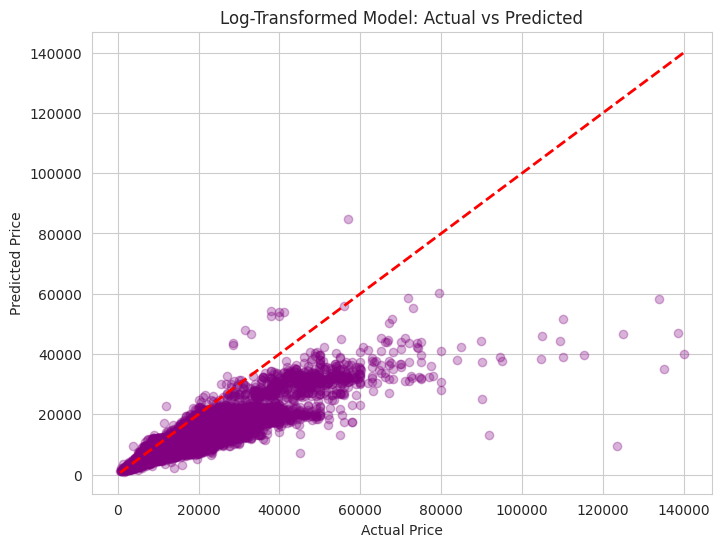

In [18]:
# --- BLOCK 10: THE LOG-TRANSFORM STRATEGY ---
print("--- Retraining with Log-Transformed Prices ---")

# 1. TRANSFORM TARGETS
# Squeeze prices: £15,000 -> 9.6 | £150,000 -> 11.9
y_train_log = torch.tensor(np.log1p(y_train.values)).view(-1, 1).float()
y_test_log = torch.tensor(np.log1p(y_test.values)).view(-1, 1).float()

# 2. RE-INITIALIZE MODEL (Fresh Start)
model_log = CarPriceNet(X_train.shape[1])
optimizer_log = optim.Adam(model_log.parameters(), lr=0.01)
criterion = nn.MSELoss()

# 3. TRAIN AGAIN
epochs = 500
loss_history_log = []

print("Training Log-Model...")
for epoch in range(epochs):
    # Forward
    y_pred_log = model_log(X_train_tensor)
    loss = criterion(y_pred_log, y_train_log) # Compare Log vs Log

    # Backward
    optimizer_log.zero_grad()
    loss.backward()
    optimizer_log.step()

    loss_history_log.append(loss.item())

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Log-Loss: {loss.item():.4f}')

# 4. EVALUATE (Convert back to Real Money)
model_log.eval()
with torch.no_grad():
    # Predict in "Log World"
    pred_log = model_log(X_test_tensor).numpy()

    # Convert back to "Real Money" using exp (exponential)
    y_pred_final = np.expm1(pred_log)
    y_test_final = y_test_tensor.numpy() # Original prices

# 5. CHECK NEW SCORE
rmse_final = np.sqrt(mean_squared_error(y_test_final, y_pred_final))
error_pct_final = (rmse_final / df['price'].mean()) * 100

print(f"\n--- FINAL LOG-MODEL RESULTS ---")
print(f"Previous Error %: {error_percentage_nn:.2f}%")
print(f"New Error %:      {error_pct_final:.2f}%")
print(f"New RMSE:         £{rmse_final:,.2f}")

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(y_test_final, y_pred_final, alpha=0.3, color='purple', label='Log-Model predictions')
plt.plot([y_test_final.min(), y_test_final.max()], [y_test_final.min(), y_test_final.max()], 'r--', lw=2)
plt.title('Log-Transformed Model: Actual vs Predicted')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()